In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Utility libs
from tqdm import tqdm
import time
import datetime
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from copy import deepcopy
import pprint
import shap
import os

In [2]:
import tensorflow as tf
import pandas as pd
import catboost
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
#from imblearn.over_sampling import SMOTE
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
data=pd.read_csv('mbti_1.csv')
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
data.describe(include='O')

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


In [4]:
data['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [6]:
dj=list(data['type'].value_counts())
dq=list(data['type'].unique())
df_123 = pd.DataFrame(list(zip(dq,dj)),
               columns =['Type', 'Val'])
df_123

,Type,Val
0,INFJ,1832
1,ENTP,1470
2,INTP,1304
3,INTJ,1091
4,ENTJ,685
5,ENFJ,675
6,INFP,337
7,ENFP,271
8,ISFP,231
9,ISTP,205


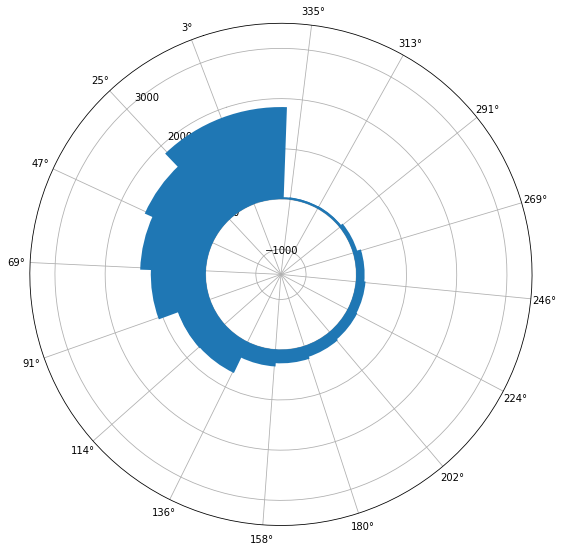

In [7]:
#Values for the x axis
ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(df_123), endpoint=False)

# Cumulative length
LENGTHS = df_123["Val"]



fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})

# Set background color to white, both axis and figure.
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2)
ax.set_ylim(-1500, 3500)

# Add geometries to the plot -------------------------------------
# See the zorder to manipulate which geometries are on top

# Add bars to represent the cumulative track lengths
ax.bar(ANGLES, LENGTHS, zorder=10)

# Add dashed vertical lines. These are just references
#ax.vlines(ANGLES, 0, 3000, color=GREY12, ls=(0, (4, 4)), zorder=11)

# Add dots to represent the mean gain
#ax.scatter(ANGLES, MEAN_GAIN, s=60, color=GREY12, zorder=11)


# Add labels for the regions -------------------------------------
# Note the 'wrap()' function.
# The '5' means we want at most 5 consecutive letters in a word, 
# but the 'break_long_words' means we don't want to break words 
# longer than 5 characters.
#REGION = ["\n".join(wrap(r, 5, break_long_words=False)) for r in REGION]
#REGION

# Set the labels
ax.set_xticks(ANGLES)
#ax.set_xticklabels(REGION, size=12);

In [8]:
# Stratify split to ensure equal distribution of data

train_data,test_data=train_test_split(data,test_size=0.2,random_state=42,stratify=data.type)

### Function to clean the text data.

In [9]:
def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.posts):
        sentence=sentence.lower()
        
#         removing links from text data
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
    
#         removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)
    
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length

In [10]:
train_data.posts,train_length=clear_text(train_data)

100%|██████████| 6940/6940 [00:03<00:00, 1904.16it/s]


In [11]:
test_data.posts,test_length=clear_text(test_data)

100%|██████████| 1735/1735 [00:00<00:00, 1937.55it/s]


In [12]:
train_data[1228]

KeyError: 1228

In [ ]:
plt.figure(figsize=(15,10))
sns.distplot(train_length,label='train data word length')
sns.distplot(test_length,label='test data word length')
plt.title('Number of words in text',fontdict={'size':20,'style':'italic'})
plt.show()

In [76]:

px.pie(train_data,names='type',title='Personality type',hole=0.3)


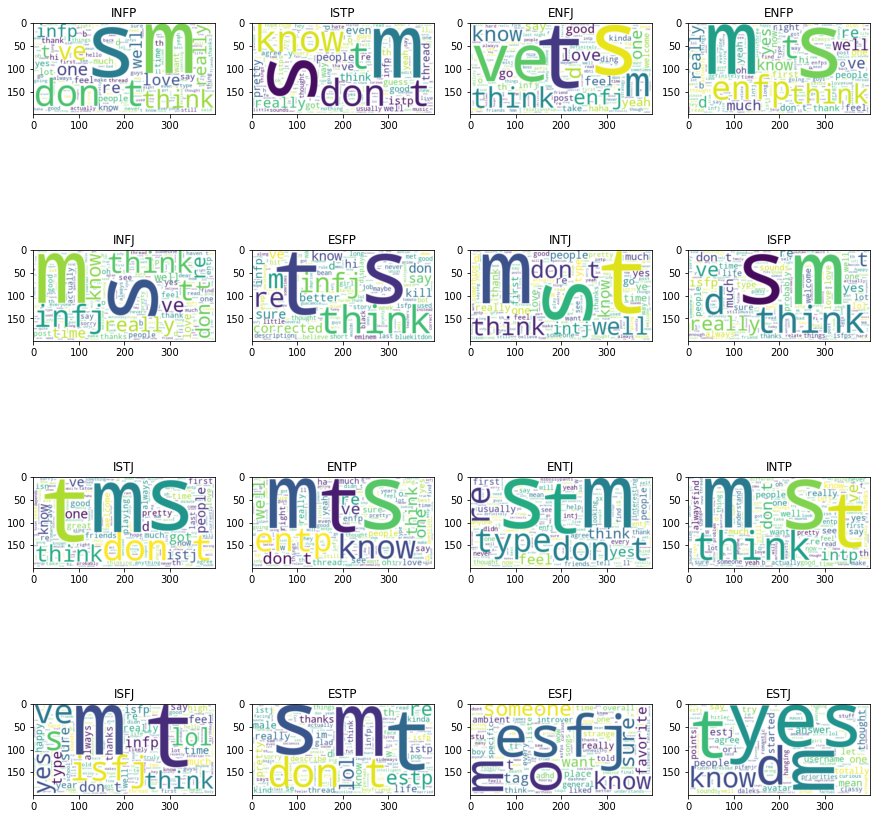

In [77]:
#train_data=train_data[train_data.posts.str.len() <= 2]
fig, ax = plt.subplots(len(train_data['type'].unique()), sharex=True, figsize=(15,len(train_data['type'].unique())))
k = 0
for i in train_data['type'].unique():
    df_4 = train_data[train_data['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=0,normalize_plurals=False,background_color="white").generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k+=1

In [171]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

<h1 style="background-color:#99b3ff;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">Tokenizing words</h1>

In [172]:
vectorizer=TfidfVectorizer( max_features=5000,stop_words='english',tokenizer=Lemmatizer())
vectorizer.fit(train_data.posts)

TfidfVectorizer(max_features=5000, stop_words='english',
                tokenizer=<__main__.Lemmatizer object at 0x00000235C9EC2DC8>)

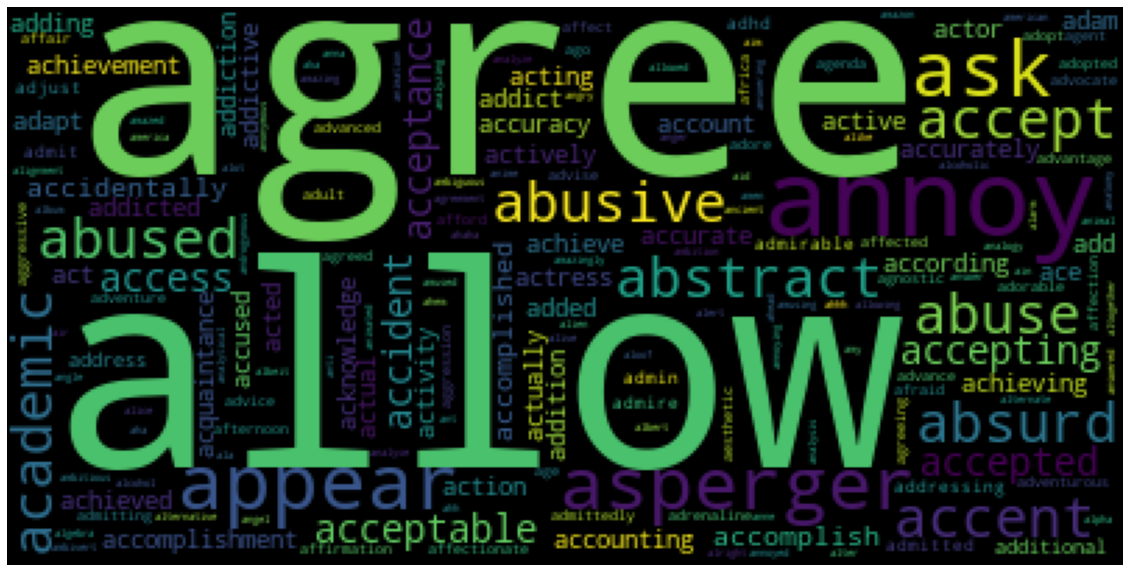

In [173]:
feature_names=vectorizer.get_feature_names()
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[50:350] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

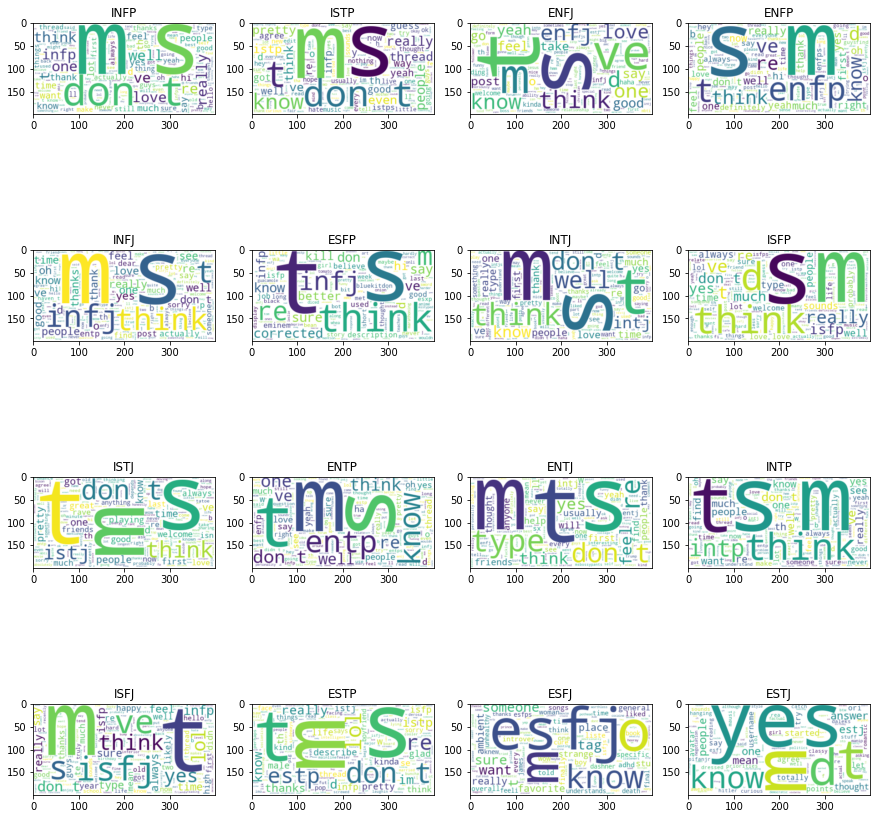

In [177]:
fig, ax = plt.subplots(len(train_data['type'].unique()), sharex=True, figsize=(15,len(train_data['type'].unique())))
k = 0
for i in train_data['type'].unique():
    df_4 = train_data[train_data['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=0,normalize_plurals=False,background_color="white").generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k+=1

In [175]:
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()

In [176]:
train_post

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.06447606, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.03124385, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05058323, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [30]:
target_encoder=LabelEncoder()
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)

<AxesSubplot:>

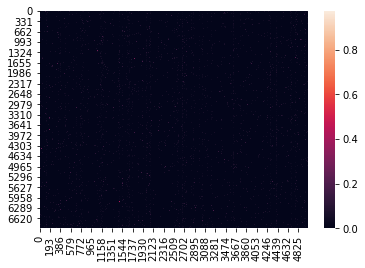

In [33]:
sns.heatmap(train_post)



<h1 style="background-color:#99b3ff;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">Model selection</h1>

In [314]:
models_accuracy={}

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Logistic Regression</h4>

In [100]:
model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
model_log.fit(train_post,train_target)

LogisticRegression(C=0.5, max_iter=3000, n_jobs=-1)

In [101]:
print('train classification report \n ',classification_report(train_target,model_log.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.86      0.16      0.27       152
        ENFP       0.81      0.65      0.72       540
        ENTJ       0.93      0.29      0.44       185
        ENTP       0.82      0.66      0.73       548
        ESFJ       0.00      0.00      0.00        34
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       1.00      0.04      0.08        71
        INFJ       0.73      0.83      0.78      1176
        INFP       0.66      0.93      0.77      1465
        INTJ       0.73      0.80      0.77       873
        INTP       0.69      0.87      0.77      1043
        ISFJ       0.89      0.24      0.38       133
        ISFP       0.86      0.26      0.40       217
        ISTJ       0.86      0.27      0.41       164
        ISTP       0.86      0.52      0.65       270

    accuracy                           0.72      

In [102]:
print('test classification report \n',classification_report(test_target,model_log.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

test classification report 
               precision    recall  f1-score   support

        ENFJ       1.00      0.08      0.15        38
        ENFP       0.76      0.53      0.62       135
        ENTJ       0.75      0.13      0.22        46
        ENTP       0.66      0.51      0.58       137
        ESFJ       0.00      0.00      0.00         8
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.64      0.71      0.67       294
        INFP       0.57      0.88      0.69       367
        INTJ       0.61      0.65      0.63       218
        INTP       0.66      0.83      0.74       261
        ISFJ       0.67      0.12      0.21        33
        ISFP       0.85      0.20      0.33        54
        ISTJ       0.60      0.07      0.13        41
        ISTP       0.68      0.45      0.54        67

    accuracy                           0.63      17

In [103]:
predolog=model_log.predict(test_post)

In [104]:
target_encoder.inverse_transform(predolog)

array(['INFP', 'INFP', 'INFJ', ..., 'INFJ', 'INFJ', 'ENTP'], dtype=object)

In [105]:
models_accuracy['logistic regression']=accuracy_score(test_target,model_log.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Linear Support Vector classifier</h4>

In [106]:
model_linear_svc=LinearSVC(C=0.1)
model_linear_svc.fit(train_post,train_target)

LinearSVC(C=0.1)

In [107]:
print('train classification report \n ',classification_report(train_target,model_linear_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n',classification_report(test_target,model_linear_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.89      0.45      0.60       152
        ENFP       0.85      0.76      0.80       540
        ENTJ       0.92      0.65      0.76       185
        ENTP       0.84      0.82      0.83       548
        ESFJ       0.83      0.29      0.43        34
        ESFP       1.00      0.11      0.19        38
        ESTJ       1.00      0.26      0.41        31
        ESTP       0.92      0.49      0.64        71
        INFJ       0.82      0.86      0.84      1176
        INFP       0.77      0.93      0.84      1465
        INTJ       0.83      0.85      0.84       873
        INTP       0.81      0.89      0.85      1043
        ISFJ       0.91      0.67      0.77       133
        ISFP       0.89      0.57      0.70       217
        ISTJ       0.87      0.66      0.75       164
        ISTP       0.89      0.83      0.86       270

    accuracy                           0.82      

In [108]:
models_accuracy['Linear Support Vector classifier']=accuracy_score(test_target,model_linear_svc.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Support Vector classifier</h4>

In [109]:
model_svc=SVC()
model_svc.fit(train_post,train_target)

SVC()

In [110]:

print('train classification report \n ',classification_report(train_target,model_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.97      0.84      0.90       152
        ENFP       0.96      0.95      0.95       540
        ENTJ       0.99      0.90      0.94       185
        ENTP       0.95      0.96      0.95       548
        ESFJ       1.00      0.56      0.72        34
        ESFP       1.00      0.37      0.54        38
        ESTJ       1.00      0.52      0.68        31
        ESTP       1.00      0.82      0.90        71
        INFJ       0.95      0.97      0.96      1176
        INFP       0.92      0.98      0.95      1465
        INTJ       0.96      0.96      0.96       873
        INTP       0.94      0.97      0.96      1043
        ISFJ       1.00      0.89      0.94       133
        ISFP       0.97      0.90      0.94       217
        ISTJ       0.94      0.92      0.93       164
        ISTP       0.97      0.94      0.95       270

    accuracy                           0.95      

In [111]:
models_accuracy['Support Vector classifier']=accuracy_score(test_target,model_svc.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Multinomial Naive Bayes</h4>

In [112]:
model_multinomial_nb=MultinomialNB()
model_multinomial_nb.fit(train_post,train_target)

MultinomialNB()

In [113]:

print('train classification report \n ',classification_report(train_target,model_multinomial_nb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_multinomial_nb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       152
        ENFP       0.90      0.02      0.03       540
        ENTJ       0.00      0.00      0.00       185
        ENTP       0.91      0.06      0.11       548
        ESFJ       0.00      0.00      0.00        34
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       0.00      0.00      0.00        71
        INFJ       0.52      0.62      0.56      1176
        INFP       0.35      0.94      0.52      1465
        INTJ       0.78      0.42      0.54       873
        INTP       0.58      0.64      0.61      1043
        ISFJ       0.00      0.00      0.00       133
        ISFP       0.00      0.00      0.00       217
        ISTJ       0.00      0.00      0.00       164
        ISTP       1.00      0.00      0.01       270

    accuracy                           0.46      

In [114]:
models_accuracy['Multinomial Naive Bayes']=accuracy_score(test_target,model_multinomial_nb.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Decision Tree Classifier</h4>

In [115]:
model_tree=DecisionTreeClassifier(max_depth=14)
model_tree.fit(train_post,train_target)

DecisionTreeClassifier(max_depth=14)

In [116]:

print('train classification report \n ',classification_report(train_target,model_tree.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_tree.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.74      0.59      0.66       152
        ENFP       0.88      0.79      0.83       540
        ENTJ       0.87      0.68      0.76       185
        ENTP       0.96      0.76      0.85       548
        ESFJ       0.93      0.38      0.54        34
        ESFP       0.67      0.26      0.38        38
        ESTJ       0.86      0.39      0.53        31
        ESTP       0.94      0.44      0.60        71
        INFJ       0.81      0.85      0.83      1176
        INFP       0.62      0.94      0.75      1465
        INTJ       0.87      0.79      0.83       873
        INTP       0.89      0.81      0.85      1043
        ISFJ       0.98      0.46      0.63       133
        ISFP       0.94      0.62      0.75       217
        ISTJ       0.96      0.52      0.67       164
        ISTP       0.99      0.70      0.82       270

    accuracy                           0.79      

In [117]:
models_accuracy['Decision Tree classifier']=accuracy_score(test_target,model_tree.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Random Forest Classifier</h4>

In [118]:
model_forest=RandomForestClassifier(max_depth=10)
model_forest.fit(train_post,train_target)

RandomForestClassifier(max_depth=10)

In [119]:

print('train classification report \n ',classification_report(train_target,model_forest.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_forest.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       1.00      0.01      0.03       152
        ENFP       1.00      0.43      0.60       540
        ENTJ       1.00      0.01      0.02       185
        ENTP       0.98      0.56      0.71       548
        ESFJ       1.00      0.03      0.06        34
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       1.00      0.01      0.03        71
        INFJ       0.84      0.82      0.83      1176
        INFP       0.44      0.99      0.61      1465
        INTJ       0.91      0.75      0.82       873
        INTP       0.80      0.88      0.84      1043
        ISFJ       1.00      0.01      0.01       133
        ISFP       1.00      0.06      0.10       217
        ISTJ       1.00      0.02      0.05       164
        ISTP       1.00      0.20      0.33       270

    accuracy                           0.66      

In [120]:
models_accuracy['Random Forest Classifier']=accuracy_score(test_target,model_forest.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">XGBoost Classifier</h4>

In [121]:
model_xgb=XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=5,n_estimators=50,learning_rate=0.1)
model_xgb.fit(train_post,train_target)

[20:03:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [122]:

print('train classification report \n ',classification_report(train_target,model_xgb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_xgb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.99      0.92      0.95       152
        ENFP       0.94      0.91      0.92       540
        ENTJ       0.99      0.90      0.94       185
        ENTP       0.94      0.91      0.92       548
        ESFJ       1.00      0.91      0.95        34
        ESFP       1.00      0.92      0.96        38
        ESTJ       1.00      0.84      0.91        31
        ESTP       1.00      0.94      0.97        71
        INFJ       0.91      0.90      0.91      1176
        INFP       0.89      0.95      0.92      1465
        INTJ       0.92      0.92      0.92       873
        INTP       0.90      0.93      0.91      1043
        ISFJ       1.00      0.96      0.98       133
        ISFP       0.99      0.92      0.95       217
        ISTJ       0.99      0.92      0.95       164
        ISTP       0.97      0.96      0.96       270

    accuracy                           0.92      

In [123]:
models_accuracy['XGBoost Classifier']=accuracy_score(test_target,model_xgb.predict(test_post))
models_accuracy

{'logistic regression': 0.6282420749279539,
 'Linear Support Vector classifier': 0.661671469740634,
 'Support Vector classifier': 0.6489913544668587,
 'Multinomial Naive Bayes': 0.37809798270893374,
 'Decision Tree classifier': 0.5089337175792508,
 'Random Forest Classifier': 0.47031700288184436,
 'XGBoost Classifier': 0.6657060518731989}

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">CatBoost Classifier</h4>

In [335]:
import catboost as cbo
class ModelOptimizer:
    best_score = None
    opt = None
    
    def __init__(self, model, X_train, y_train, categorical_columns_indices=None, n_fold=3, seed=2405, early_stopping_rounds=30, is_stratified=True, is_shuffle=True):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.categorical_columns_indices = categorical_columns_indices
        self.n_fold = n_fold
        self.seed = seed
        self.early_stopping_rounds = early_stopping_rounds
        self.is_stratified = is_stratified
        self.is_shuffle = is_shuffle
        
        
    def update_model(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self.model, k, v)
            
    def evaluate_model(self):
        pass
    
    def optimize(self, param_space, max_evals=10, n_random_starts=2):
        start_time = time.time()
        
        @use_named_args(param_space)
        def _minimize(**params):
            self.model.set_params(**params)
            return self.evaluate_model()
        
        opt = gp_minimize(_minimize, param_space, n_calls=max_evals, n_random_starts=n_random_starts, random_state=2405, n_jobs=-1)
        best_values = opt.x
        optimal_values = dict(zip([param.name for param in param_space], best_values))
        best_score = opt.fun
        self.best_score = best_score
        self.opt = opt
        
        print('optimal_parameters: {}\noptimal score: {}\noptimization time: {}'.format(optimal_values, best_score, time.time() - start_time))
        print('updating model with optimal values')
        self.update_model(**optimal_values)
        plot_convergence(opt)
        return optimal_values
class CatboostOptimizer(ModelOptimizer):
    def evaluate_model(self):
        validation_scores = cbo.cv(cbo.Pool(self.X_train,self.y_train,cat_features=self.categorical_columns_indices),
        self.model.get_params(), 
        nfold=self.n_fold,
        stratified=self.is_stratified,
        seed=self.seed,
        early_stopping_rounds=self.early_stopping_rounds,
        shuffle=self.is_shuffle,
#         metrics='auc',
        plot=False)
        self.scores = validation_scores
        test_scores = validation_scores.iloc[:, 2]
        best_metric = test_scores.max()
        return 1 - best_metric

In [336]:
greedy_cb = cbo.CatBoostClassifier(
    loss_function='MultiClass',
    task_type="GPU",
    learning_rate=0.01,
    iterations=2000,
    od_type="Iter",
    early_stopping_rounds=500,
    random_seed=24,
    silent=True
)


In [337]:
from sklearn.metrics import confusion_matrix
def qwk(act,pred,n=4,hist_range=(0,3)):
    
    O = confusion_matrix(act,pred)
    O = np.divide(O,np.sum(O))
    
    W = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            W[i][j] = ((i-j)**2)/((n-1)**2)
            
    act_hist = np.histogram(act,bins=n,range=hist_range)[0]
    prd_hist = np.histogram(pred,bins=n,range=hist_range)[0]
    
    E = np.outer(act_hist,prd_hist)
    E = np.divide(E,np.sum(E))
    
    num = np.sum(np.multiply(W,O))
    den = np.sum(np.multiply(W,E))
        
    return 1-np.divide(num,den)

optimal_parameters: {'learning_rate': 0.8}
optimal score: 0.8633346074372318
optimization time: 2831.9654920101166
updating model with optimal values


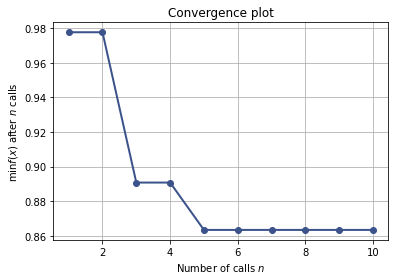

In [338]:
cb_optimizer = CatboostOptimizer(greedy_cb,train_post,train_target)
params_space = [Real(0.01, 0.8, name='learning_rate'),]
cb_optimal_values = cb_optimizer.optimize(params_space)

In [339]:
cb_optimal_values


{'learning_rate': 0.8}

In [344]:
cb = cbo.CatBoostClassifier(n_estimators=4000,
                         one_hot_max_size=2,
                         loss_function='MultiClass',
                         eval_metric='MultiClass',
                         task_type='CPU',                
                         random_seed=5, 
                         use_best_model=True,
                         silent=True
                        )

In [ ]:
one_cb_optimizer = CatboostOptimizer(cb, train_post,train_target)
params_space = [Real(0.01, 0.8, name='learning_rate'), 
                Integer(2, 10, name='max_depth'), 
                Real(0.5, 1.0, name='colsample_bylevel'), 
                Real(0.0, 100, name='bagging_temperature'), 
                Real(0.0, 100, name='random_strength'), 
                Real(1.0, 100, name='reg_lambda')]
one_cb_optimal_values = one_cb_optimizer.optimize(params_space, max_evals=40, n_random_starts=4)

In [ ]:
one_cb_optimizer.model.get_params()

In [124]:
model_cat=CatBoostClassifier(loss_function='MultiClass',eval_metric='MultiClass',task_type='GPU',verbose=False)
model_cat.fit(train_post,train_target)

In [125]:

print('train classification report \n ',classification_report(train_target,model_cat.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_cat.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.84      0.53      0.65       152
        ENFP       0.77      0.72      0.74       540
        ENTJ       0.86      0.55      0.67       185
        ENTP       0.76      0.74      0.75       548
        ESFJ       1.00      0.35      0.52        34
        ESFP       1.00      0.13      0.23        38
        ESTJ       1.00      0.29      0.45        31
        ESTP       0.97      0.48      0.64        71
        INFJ       0.76      0.78      0.77      1176
        INFP       0.74      0.87      0.80      1465
        INTJ       0.77      0.76      0.76       873
        INTP       0.71      0.84      0.77      1043
        ISFJ       0.86      0.62      0.72       133
        ISFP       0.80      0.60      0.69       217
        ISTJ       0.85      0.61      0.71       164
        ISTP       0.85      0.71      0.78       270

    accuracy                           0.76      

In [126]:
models_accuracy['CatBoost Classifier']=accuracy_score(test_target,model_cat.predict(test_post))

In [134]:
models_accuracy



{'logistic regression': 0.6282420749279539,
 'Linear Support Vector classifier': 0.661671469740634,
 'Support Vector classifier': 0.6489913544668587,
 'Multinomial Naive Bayes': 0.37809798270893374,
 'Decision Tree classifier': 0.5089337175792508,
 'Random Forest Classifier': 0.47031700288184436,
 'XGBoost Classifier': 0.6657060518731989,
 'CatBoost Classifier': 0.6657060518731989}

In [128]:
models_accuracy.keys()

dict_keys(['logistic regression', 'Linear Support Vector classifier', 'Support Vector classifier', 'Multinomial Naive Bayes', 'Decision Tree classifier', 'Random Forest Classifier', 'XGBoost Classifier', 'CatBoost Classifier'])

In [129]:
predy=model_cat.predict(test_post)

In [130]:
#import numpy as np
#predy=predy.astype(np.int)

In [131]:
#y=target_encoder.inverse_transform(predy)
accuracy_score(target_encoder.inverse_transform(test_target),target_encoder.inverse_transform(model_cat.predict(test_post)))

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
accuarcy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])

In [ ]:
accuarcy.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

### Catboost model seems to perform well in predicting values.

<font style="color: red;font-size:200%;text-align:center;border-radius: 15px 50px;padding: 5px "><center>Hope you liked this notebook. If you did please upvote it!! If having any query or suggestion, feel free to ask in comment section.</center></font>